In [1]:
%reset
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
from matplotlib import units
from tensorflow.keras.optimizers import Adam
import os
from glob import glob
import shutil
import time
from IPython.display import clear_output
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
import shutil
import PIL
from tensorflow.keras import layers
AUTOTUNE = tf.data.AUTOTUNE

In [145]:
file=glob('./dataset/*/*/*.jpg')
for x in file:
    im1=PIL.Image.open(str(x))
    if im1.mode!="RGB":
        print(x)
        print(im1.mode)
        #os.remove(x)

In [2]:
print(f"Number of dogs: {len(glob('./PetImages/dog/*'))}\nNumber of cats: {len(glob('./PetImages/cat/*'))}")

Number of dogs: 12500
Number of cats: 12500


In [3]:
image_count = len(list(glob('./dataset/train/*/*.jpg')))
print(image_count)

19925


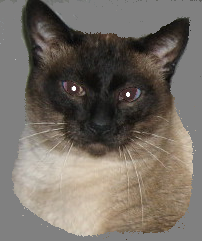

In [121]:
PIL.Image.open(str('./dataset/train/Cat\\10874.jpg'))
#print(image.format)


In [35]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
batch_size = 32
img_height = 150
img_width = 150
dtrain = tf.keras.utils.image_dataset_from_directory(
  './dataset/train/',
  image_size=(img_height, img_width),
  color_mode="rgb",
  batch_size=batch_size)

dtest = tf.keras.utils.image_dataset_from_directory(
  './dataset/val/',
  image_size=(img_height, img_width),
  color_mode="rgb",
  batch_size=batch_size)

Found 19925 files belonging to 2 classes.
Found 4985 files belonging to 2 classes.


In [5]:
class_names = dtrain.class_names
print(class_names)

['Cat', 'Dog']


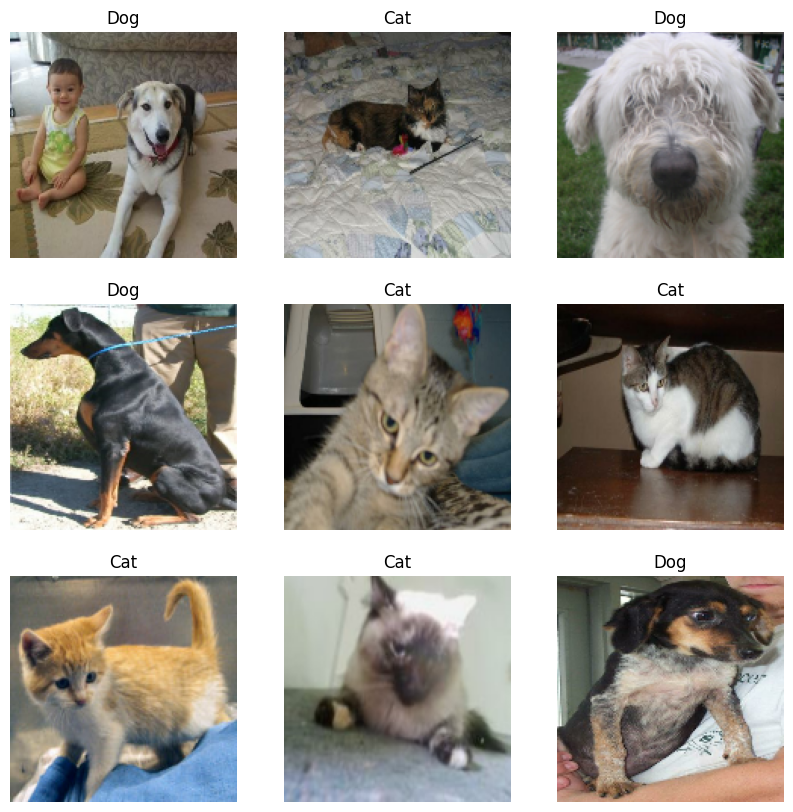

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in dtrain.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [7]:
dtrain = dtrain.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
dtest = dtest.cache().prefetch(buffer_size=AUTOTUNE)

In [99]:
classes=len(class_names)
opt=tf.keras.optimizers.Adam(0.001)
model=tf.keras.models.Sequential()
model.add(layers.Rescaling(1./255,input_shape=(img_height, img_width, 3)))
model.add(layers.RandomFlip("horizontal",input_shape=(img_height, img_width, 3)))
model.add(layers.RandomRotation(0.1))
model.add(layers.RandomZoom(0.1))
model.add(layers.Conv2D(16,3,padding="same",activation="relu"))
model.add(layers.MaxPool2D())
model.add(layers.Dropout(0.2))
model.add(layers.Conv2D(32,3,padding="same",activation="relu"))
model.add(layers.MaxPool2D())
model.add(layers.Conv2D(64,3,padding="same",activation="relu"))
model.add(layers.MaxPool2D())
model.add(layers.Flatten())
model.add(layers.Dense(128,activation="relu"))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(classes))

model.compile(optimizer=opt,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [100]:
history = model.fit(dtrain,validation_data=dtest,epochs=20)

Epoch 1/20
623/623 [==============================] - 184s 290ms/step - loss: 0.6759 - accuracy: 0.5832 - val_loss: 0.6115 - val_accuracy: 0.6684
Epoch 2/20
623/623 [==============================] - 181s 290ms/step - loss: 0.6091 - accuracy: 0.6726 - val_loss: 0.5586 - val_accuracy: 0.7121
Epoch 3/20
623/623 [==============================] - 178s 285ms/step - loss: 0.5519 - accuracy: 0.7219 - val_loss: 0.5169 - val_accuracy: 0.7438
Epoch 4/20
623/623 [==============================] - 178s 285ms/step - loss: 0.5152 - accuracy: 0.7481 - val_loss: 0.4765 - val_accuracy: 0.7725
Epoch 5/20
623/623 [==============================] - 178s 286ms/step - loss: 0.4895 - accuracy: 0.7638 - val_loss: 0.4869 - val_accuracy: 0.7649
Epoch 6/20
623/623 [==============================] - 204s 327ms/step - loss: 0.4646 - accuracy: 0.7795 - val_loss: 0.4529 - val_accuracy: 0.7858
Epoch 7/20
623/623 [==============================] - 191s 306ms/step - loss: 0.4460 - accuracy: 0.7917 - val_loss: 0.4335 -

In [42]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 random_flip_2 (RandomFlip)  (None, 150, 150, 3)       0         
                                                                 
 random_rotation_2 (RandomRo  (None, 150, 150, 3)      0         
 tation)                                                         
                                                                 
 random_zoom_2 (RandomZoom)  (None, 150, 150, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 150, 150, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 75, 75, 16)       0         
 2D)                                                  

In [101]:
model.save("modeldogcat.model")

INFO:tensorflow:Assets written to: modeldogcat.model\assets


INFO:tensorflow:Assets written to: modeldogcat.model\assets


1/1 [==============================] - 0s 27ms/step
This image used to be Cat 
but most likely belongs to Dog 
with a 74.41 percent confidence.


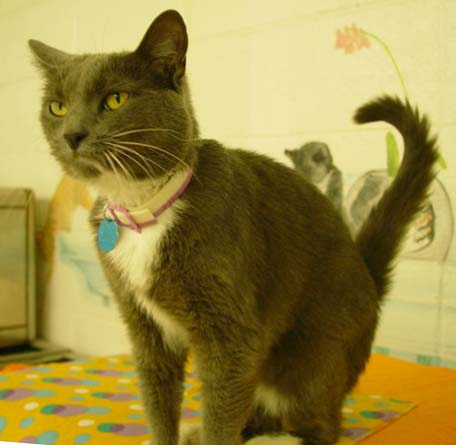

In [168]:
from random import random
img_paths = glob('./dataset/val/*/*.jpg')
ind=int(random()*len(img_paths)-1)
img = tf.keras.utils.load_img(
    img_paths[ind], target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])
print(
    "This image used to be {} \nbut most likely belongs to {} \nwith a {:.2f} percent confidence."
    .format(img_paths[ind].split("\\")[-2],class_names[np.argmax(score)], 100 * np.max(score))
)
PIL.Image.open(img_paths[ind])

In [107]:
img_paths[ind].split("\\")[-2]

'Cat'

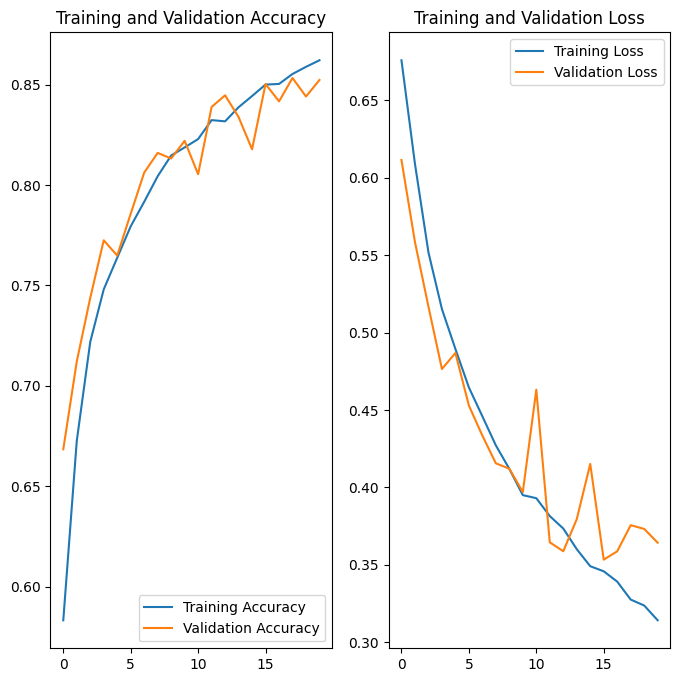

In [130]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(20)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [177]:
img_paths = glob('./dataset/*/*/*.jpg') # assuming you point to the directory containing the label folders.

bad_paths = []

for image_path in img_paths:
    try:
      img_bytes = tf.io.read_file(image_path)
      decoded_img = tf.io.decode_image(img_bytes)
    except tf.errors.InvalidArgumentError as e:
      print(f"Found bad path {image_path}...{e}")
      bad_paths.append(image_path)

    print(f"{image_path}: OK")


./dataset\train\Cat\0.jpg: OK
./dataset\train\Cat\1000.jpg: OK
./dataset\train\Cat\10000.jpg: OK
./dataset\train\Cat\10001.jpg: OK
./dataset\train\Cat\10002.jpg: OK
./dataset\train\Cat\10003.jpg: OK
./dataset\train\Cat\10004.jpg: OK
./dataset\train\Cat\10005.jpg: OK
./dataset\train\Cat\10006.jpg: OK
./dataset\train\Cat\10007.jpg: OK
./dataset\train\Cat\10008.jpg: OK
./dataset\train\Cat\10009.jpg: OK
./dataset\train\Cat\1001.jpg: OK
./dataset\train\Cat\10010.jpg: OK
./dataset\train\Cat\10011.jpg: OK
./dataset\train\Cat\10012.jpg: OK
./dataset\train\Cat\10013.jpg: OK
./dataset\train\Cat\10014.jpg: OK
./dataset\train\Cat\10015.jpg: OK
./dataset\train\Cat\10016.jpg: OK
./dataset\train\Cat\10019.jpg: OK
./dataset\train\Cat\10020.jpg: OK
./dataset\train\Cat\10021.jpg: OK
./dataset\train\Cat\10022.jpg: OK
./dataset\train\Cat\10023.jpg: OK
./dataset\train\Cat\10024.jpg: OK
./dataset\train\Cat\10025.jpg: OK
./dataset\train\Cat\10026.jpg: OK
./dataset\train\Cat\10028.jpg: OK
./dataset\train\Cat\

In [178]:

print("BAD PATHS:")
for bad_path in bad_paths:
    print(f"{bad_path}")

BAD PATHS:


In [ ]:
#import splitfolders
#splitfolders.ratio('PetImages', output="./Test", seed=1337, ratio=(.8, 0.2))

In [ ]:
'''
classofpet={0:"dog",1:"cat"}
dogfile = list(map(lambda x : x.split("/")[2].replace("\\","."),glob('./PetImages/dog/*')))
catfile = list(map(lambda x : x.split("/")[2].replace("\\","."),glob('./PetImages/cat/*')))
dfdog=pd.DataFrame({"file":dogfile})
dfcat=pd.DataFrame({"file":catfile})
dfdog["classes"]=dfdog.file.apply(lambda x : x.split(".")[0])
dfcat["classes"]=dfcat.file.apply(lambda x : x.split(".")[0])
dfdogtrain,dfdogtest=train_test_split(dfdog,test_size=0.2)
dfcattrain,dfcattest=train_test_split(dfcat,test_size=0.2)
dftrain=pd.concat([dfdogtrain,dfcattrain]).reset_index()
dftest=pd.concat([dfdogtest,dfcattest]).reset_index()
del dftest["index"]
del dftrain["index"]
del dfdogtrain,dfdogtest,dfcattrain,dfcattest,dfdog,dfcat,dogfile,catfile
'''